In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import geopandas as gpd
import pyproj
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

### Greenspace data prep functions

In [2]:
def generate_aeqd_params(val):
    """
    val:iterable of lat, lon coordinates for a single point
    reutrns: proejction string for reprojecting points to the Azimuthal
            equidistant projection.
            This string is a required input for gpd.GeoDataFrame.to_crs
    The aeqd projection allows us to calculate accurate circular buffers around 
    a point by centering the projection at that point.
    """
    lat, lon = val[0], val[1]
    aeqd_crs = pyproj.Proj(proj='aeqd'
                           , ellps='WGS84'
                           , datum='WGS84'
                           , lat_0=lat
                           , lon_0=lon
                          ).srs
    return aeqd_crs

def get_buffer(val):
    '''
    things.
    '''
    coords = val[0]
    lat, lon = coords[0], coords[1]
    prj_str = val[1]
    
    geom = gpd.points_from_xy([lon], [lat])
    point_gdf = gpd.GeoDataFrame([[coords]]
                                 , columns=['coords']
                                 , geometry=geom
                                 , crs='EPSG:4326')
    point_gdf = point_gdf.to_crs(crs=prj_str)
    point_gdf['buffer'] = point_gdf['geometry'].buffer(1609.34 * .5) #half mile, in meters
    
    return point_gdf['buffer'].to_crs(epsg=4326)

### Process green space data, get a buffer and project back to wgs84

In [3]:
# load the greenspace coords df
grndf = pd.read_excel('data/sgf_greenspace_coordinates.xlsx')

# # the coordinates are in one large string.
# # need to split on the comma to get separate lat/lon values. 
# # then send to to a list format, create a new df with the values and merge into grndf.
# # now we have separate lat, lon columns. (still strings)
# latlons = grndf['coordinates'].apply(str.split, sep=',').to_list()
# latlons_df = pd.DataFrame(latlons, columns=['lat', 'lon'], index = grndf.index)
# grndf = pd.concat([grndf, latlons_df], axis=1)

grndf['coordinates'] = grndf['coordinates'].apply(str.split, sep=',')

latlons = grndf['coordinates'].to_list()
latlons_df = pd.DataFrame(latlons, columns=['lat', 'lon'], index = grndf.index)
grndf = pd.concat([grndf, latlons_df], axis=1)

# convert grndf into a GeoDataFrame.
# need two extra pieces of information to create it:
#  1. figure out the crs used in gathering the coords from google maps (crs is WGS84; epsg = 4326).
#     I just googled it (:
#  2. create a geometry object to be assigned to the gdf. this is the object used in spatial calculations

# create a shapely GeometryArray of Point objects generated by the lon/lat pairs.
grn_geometry = gpd.points_from_xy(grndf['lon'], grndf['lat'])
# set to epsg for WSG84 (crs used in good maps) and assign geometry
grngdf = gpd.GeoDataFrame(grndf, geometry=grn_geometry, crs='EPSG:4326')

# to calculate a buffer around the park coords, need to first project to Azimuthal Equidistant crs.
# here, we're getting the projection string, which we pass to the function that projects it to the right crs
# each row needs its own projection string generated, its own buffer calculated based on that projection, and it needs it
#   buffer polygon projected *back* to wgs84
# grngdf['aeqd_proj_str'] = grngdf['coordinates'].apply(generate_aeqd_params)
projection_strings = grngdf['coordinates'].apply(generate_aeqd_params)
projection_inputs = pd.Series(list(zip(grngdf['coordinates'], projection_strings)), name='aeqd projection inputs')
# clarifying that the buffer thats returned has been projected *back* to wgs84
grngdf['wgs84_buffer'] = projection_inputs.apply(get_buffer)

# need to switch geomtries from the coordinates (Points) to the buffer shape (Polygon)
# going to change the name of the df, to keep them straight.
buffergdf = grngdf.rename(columns={'geometry':'wgs84_point'})
buffergdf = buffergdf.set_geometry('wgs84_buffer')
buffergdf = buffergdf.rename(columns={'wgs84_buffer':'geometry'})

### Load census block group data and narrow down to relevant block groups (sgf area)

block group shapefiles downloaded from Missouri Census Burearu site:
https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html

the web interface for actual download -- https://www.census.gov/cgi-bin/geo/shapefiles/index.php

this link explains spatial joins -- https://geopandas.org/mergingdata.html

In [4]:
# State block groups
# crs is epsg=4269
blockgdf = gpd.read_file('data/tl_2019_29_bg.shp')
blockgdf.columns = [i.lower() for i in blockgdf.columns]

# read city file, narrow down to springfield
citygdf = gpd.read_file('data/City_Limits.shp')
citygdf = citygdf.to_crs(epsg=4269)
citygdf = citygdf.loc[citygdf['NAME']=='SPRINGFIELD']

# create gdf from internal points on block data.
intpt_geom = gpd.points_from_xy(blockgdf['intptlon'], blockgdf['intptlat'])
intptgdf = gpd.GeoDataFrame(blockgdf.drop(columns='geometry')
                             , geometry=intpt_geom
                             , crs='EPSG:4269')

# use the internal points gdf to do a spatial join on the city limits.
city_geoids = gpd.sjoin(intptgdf, citygdf, op='within', how='inner')['geoid'].values
blockgdf = blockgdf.loc[blockgdf['geoid'].isin(city_geoids)]

### For each block group, calculate how many parks are close

In [5]:
# project buffer gdf to crs from block group data
prj_buffergdf = buffergdf.to_crs(epsg=4269)

# doing a spatial join
# checking if internal points of city block groups are withing the buffer of a park
joindf = gpd.sjoin(intptgdf, prj_buffergdf, op='within', how='left')
# block groups with NaN values for the park data (e.g. 'name') are in the buffer of 0 parks.
# the count returns 0 for the nans, so it works
park_count = joindf.groupby('geoid', as_index=True)['name'].count()
park_count.name='park_count'

# add park_count series to the blockgdf columns
blockgdf = blockgdf.merge(park_count, left_on='geoid', left_index=False, right_index=True)

## Vizualize

Project everybody to census crs for viz. (choice of epsg=4269 is subjective)

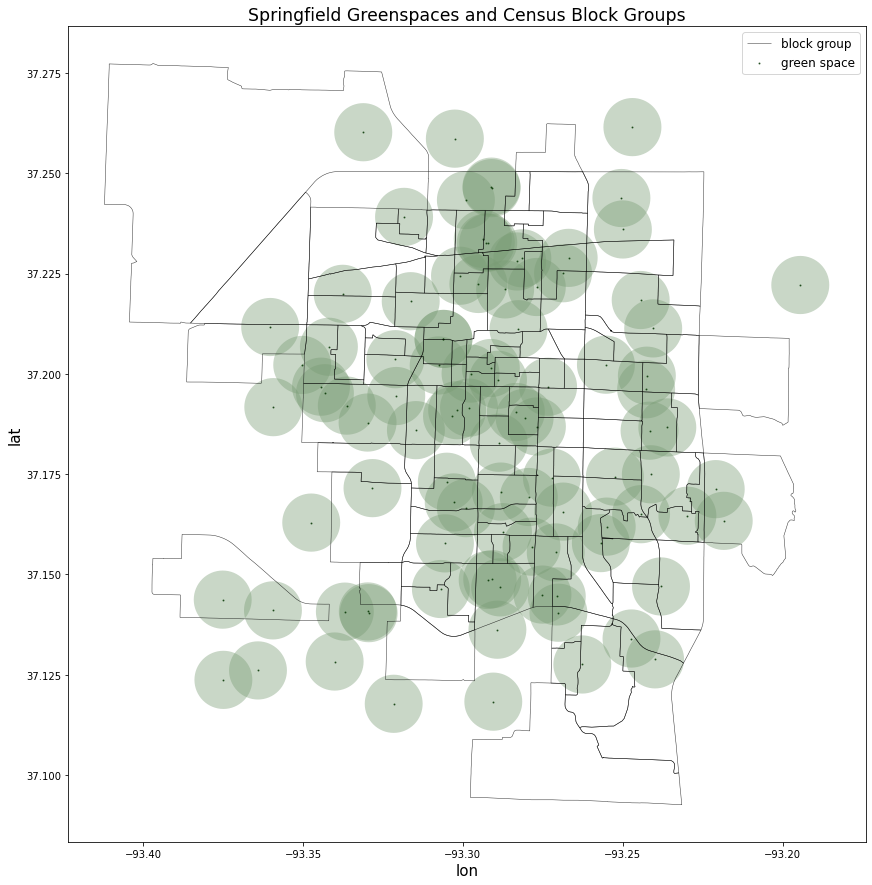

In [6]:
prj_buffergdf = buffergdf.to_crs(epsg=4269)
prj_grngdf = grngdf.to_crs(epsg=4269)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
blockgdf.boundary.plot(ax=ax, color='black', linewidth=.5, alpha=.8, label='block group')
prj_buffergdf.plot(ax=ax, color='xkcd:gray green', alpha=.4, label='1/2 mile radius')
prj_grngdf.plot(ax=ax, color='xkcd:dark green', alpha=.7, markersize=1, label='green space')

ax.legend(fontsize='large')
ax.set_ylabel('lat', size=15)
ax.set_xlabel('lon', size=15)
plt.title('Springfield Greenspaces and Census Block Groups', fontsize='xx-large')

plt.savefig('images/sgf_greenspace_with_buffer_filtered.png')

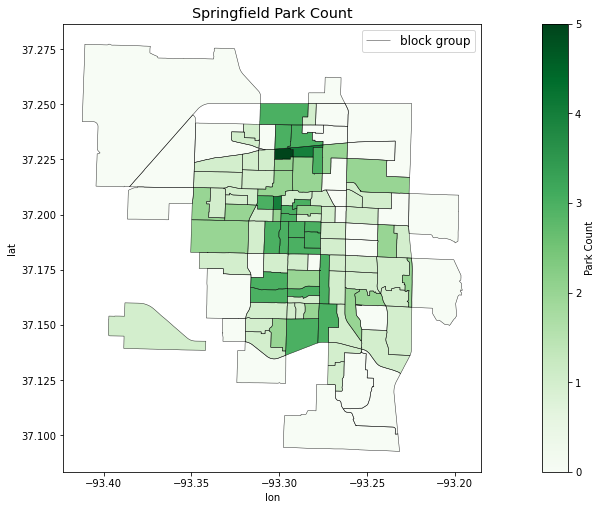

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)

blockgdf.boundary.plot(ax=ax, color='black', linewidth=.5, alpha=.8, label='block group')
blockgdf.plot(ax=ax
              , column=blockgdf['park_count']
              , cmap='Greens'
              , legend=True
              , cax=cax
              , legend_kwds={'label': "Park Count"}
             )
ax.legend(fontsize='large')
ax.set_ylabel('lat', size=10)
ax.set_xlabel('lon', size=10)
ax.set_title('Springfield Park Count', fontsize='x-large')

plt.savefig('images/sgf_park_count.png')

reprojecting a geodataframe to aeqd
code from https://automating-gis-processes.github.io/site/2018/notebooks/L2/projections.html

original code from https://gis.stackexchange.com/questions/289044/creating-buffer-circle-x-kilometers-from-point-using-python